epoch  0  : mse_train =  0.013811152677360735
epoch  0  : mse_test =  0.013256894340601798
--------------------------------------------------------
epoch  1  : mse_train =  0.04991131060182033
epoch  1  : mse_test =  0.05320691902169384
--------------------------------------------------------
epoch  2  : mse_train =  0.009369509816427986
epoch  2  : mse_test =  0.008129474727807258
--------------------------------------------------------
epoch  3  : mse_train =  0.009296615397278664
epoch  3  : mse_test =  0.008152256088718267
--------------------------------------------------------
epoch  4  : mse_train =  0.009268281367861921
epoch  4  : mse_test =  0.008096133336881467
--------------------------------------------------------
epoch  5  : mse_train =  0.009258408320914662
epoch  5  : mse_test =  0.008088888023244032
--------------------------------------------------------
epoch  6  : mse_train =  0.009248770597715525
epoch  6  : mse_test =  0.008086131491925353
-----------------------

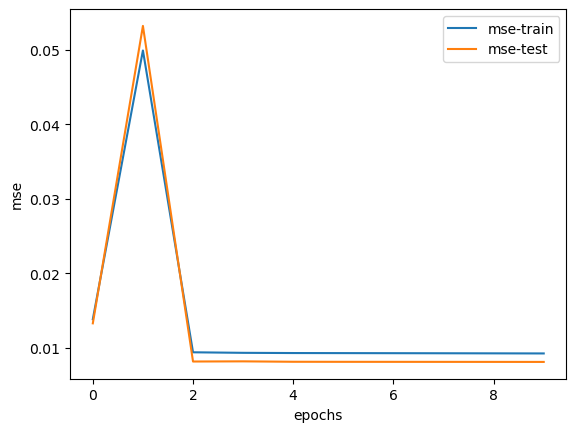

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
from sklearn.preprocessing import normalize

"""
    Prepairing Data
"""

#Loading data
data = pd.read_excel("Desktop/daily-mean-temperatures.xlsx")
data = data.to_numpy()
 
# Normalize Data
mn = np.min(data)
mx = np.max(data)
#data_norm = (data - mn)/(mx - mn)
data_norm= normalize(data, norm='max', axis=0)

# use of the previous four steps
step = 4
X = np.zeros(shape=(len(data_norm) - step ,step))
Y = []
for i in range(len(data_norm)-step):
    X[i,:] = data_norm[i:i+step , 0]
    Y.append(data_norm[i+step,0])
Y = np.array(Y)

# Splitting data to train and test
trn_tst_split = int(0.7 * len(X))
X_train = X[0:trn_tst_split]
Y_train = Y[0:trn_tst_split]

X_test = X[trn_tst_split:]
Y_test = Y[trn_tst_split:]

"""
 ---- Structure of Neural Network ----
"""
n0 = X_train.shape[1] # input layer
n1 = 8 # first hidden layer
n2 = 4 # second hidden layer
n3 = 1 # output layer

w1 = np.random.uniform(low=-1,high= +1,size=(n1,n0))
w2 = np.random.uniform(low=-1,high= +1,size=(n2,n1))
w3 = np.random.uniform(low=-1,high= +1,size=(n3,n2))

# activation function
def activation(x):
    y = 1/(1 + np.exp(-1 * x))
    return y

# feedforward algorithm
def feedforward(input_net):
    # inputs * w1 --> x1 , y1= sigmoid(x1) , y1 * w2 --> x2
    # y2 = sigmoid(x2) , y2 * w3 --> x3 , y3 = x3 , y3 : output
    x1 = np.dot(input_net , w1.T)
    y1 = activation(x1)
    x2 = np.dot(y1 , w2.T)
    y2 = activation(x2)
    x3 = np.dot(y2 , w3.T)
    y3 = x3

    return y1 , y2 , y3

# Backpropagation
def d_activation(out):
    # y = sigmoid(x) --> d_y = y * (1 - y)
    d_y = out * ( 1 - out)
    return d_y

epochs = 10
Jacobian = np.zeros(shape=(len(X_train) , n1*n0 + n2*n1 + n3*n2))
I = np.eye(n1*n0 + n2*n1 + n3*n2)
mu_temp = 0.01
w_all = np.zeros(shape= (1, n1*n0 + n2*n1 + n3*n2))
w_all[:,0:n1*n0] = np.reshape(w1,newshape=(n1*n0,))
w_all[:, n1*n0 : n1*n0+n2*n1] = np.reshape(w2,newshape=(n2*n1,))
w_all[:, n1*n0+n2*n1 : n1*n0+n2*n1+n3*n2] = np.reshape(w3,newshape=(n3*n2,))

mse_train =  []
mse_test = []
for i in range(epochs):
    error_train = np.zeros(shape=(len(X_train),1))
    for j in range(len(X_train)):
        input = X_train[j] # shape input = (n0,)
        input = np.reshape(input , newshape=(1,n0)) # shape input = (1,n0)
        target = Y_train[j]

        y1 , y2 , y3 = feedforward(input)
        error = target - y3
        error_train[j,0] = error
        d_f3 = np.array([1])

        d_f2 = d_activation(y2)
        diag_d_f2 = np.diagflat(d_f2)

        d_f1 = d_activation(y1)
        diag_d_f1 = np.diagflat(d_f1)

        temp1 = -1 * d_f3  # d-error/d-w = d-error/d-y3 * d-y3/d-x3 * ...
        temp2 = temp1 * w3 #np.dot(temp1 , w3)
        temp3 = np.dot(temp2 , diag_d_f2)
        temp4 = np.dot(temp3 , w2)
        temp5 = np.dot(temp4 , diag_d_f1)
        temp5 = temp5.T
        temp6 = np.dot(temp5 , input)

        gw1 = temp6
        # gw2 = -1 * d_f3 * w3 * diag_d_f2).T * y1
        gw2 =  np.dot(temp3.T , y1)
        # w3 = -1 * d_f3 * y2
        gw3 =  np.dot(temp1.T , y2)
        Jacobian[j,0:n1*n0] = np.reshape(gw1,newshape=(n1*n0,))
        Jacobian[j,n1*n0 : n1*n0+n2*n1] = np.reshape(gw2,newshape=(n2*n1,))
        Jacobian[j,n1*n0+n2*n1 : ] = np.reshape(gw3,newshape=(n3*n2,))
    mu = mu_temp * error_train.T.dot(error_train)
    hessian = np.linalg.inv(Jacobian.T.dot(Jacobian) + mu*I)
    temp = hessian.dot(Jacobian.T)
    temp = temp.dot(error_train)
    w_all = w_all - temp.T
    w1 = np.reshape(w_all[:,0:n1*n0],newshape=(n1,n0))
    w2 = np.reshape(w_all[:,n1*n0 : n1*n0 + n2*n1] , newshape=(n2,n1))
    w3 = np.reshape(w_all[:,n1*n0 + n2*n1 : ] , newshape=(n3,n2))

    output_train = []
    for k in range(len(X_train)):
        input = X_train[k]
        _,_,y3 = feedforward(input)
        output_train.append(y3)

    output_test = []
    for k in range(len(X_test)):
        input = X_test[k]
        _,_,y3 = feedforward(input)
        output_test.append(y3)

    mse_train.append(mse(Y_train,output_train))
    mse_test.append(mse(Y_test,output_test))

    print('epoch ' , i, ' : mse_train = ', mse(Y_train,output_train))
    print('epoch ', i, ' : mse_test = ', mse(Y_test, output_test))
    print('--------------------------------------------------------')

from sklearn.metrics import r2_score
R2_trian = r2_score(Y_train,output_train)
R_train = np.sqrt(R2_trian)
R2_test = r2_score(Y_test,output_test)
R_test = np.sqrt(R2_test)

import matplotlib.pyplot as plt

plt.plot(mse_train,label='mse-train')
plt.plot(mse_test, label='mse-test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('mse')
plt.show()